## Notebook Page

In [23]:
import mechwolf as mw
import graphviz
import math
from datetime import timedelta
from astropy.table import QTable, Table, Column
from sigfig import round
import json

In [24]:
with open('addition_reagents.json') as f:
    data = json.load(f)

### Reagents

In [25]:
print(f"The limiting reagent is {data['limiting reagent']}")
mw_limiting = 218.15

try:
    mass_scale = float(data['mass scale'])
except:
    print('Invalid input: numerical values only')

moles = mass_scale / mw_limiting

print(f'\nMoles: {moles}')

The limiting reagent is C-4 Benzylated Enone

Moles: 0.0022920009168003667


In [26]:
try:
    concentration = float(data['concentration'])
except:
    print('Invalid input: numerical values only')
    
volume = (moles * 1000) / concentration

print(f'\nVolume: {volume} mL')


Volume: 11.460004584001831 mL


In [27]:
# TODO for Tu-Anh: do we need solvent volume for the solids

class Reagent:
    
    def __init__(self, reagent):
        assert 'name' in reagent, 'ERROR: one of the reagents does not have a name field'
        assert 'inChi' in reagent, f'Error: {reagent["name"]} does not have an inChi field'
        assert 'inChi Key' in reagent, f'Error: {reagent["name"]} does not have an inChi key field'
        assert 'molecular weight' in reagent, f'Error: {reagent["name"]} does not have a molecular weight field'
        assert 'eq' in reagent, f'Error: {reagent["name"]} does not have an eq field'
        assert 'syringe' in reagent, f'Error: {reagent["name"]} does not have an syringe # field'
        
        self.name = reagent['name']
        self.inChi = reagent['inChi']
        self.mol_weight = reagent['molecular weight']
        self.eq = reagent['eq']
        self.syringe = reagent['syringe']
        self.moles = round(moles * self.eq, decimals = 4)
        self.mass = round(self.moles * self.mol_weight, decimals = 4)
        
    def __str__(self):
        return f"{self.name}"
    
class Solid(Reagent):
    
    def __init__(self, reagent):
        super().__init__(reagent)
        
        assert 'solvent eq' in reagent, f'Error: {reagent["name"]} does not have a solvent eq field'
        self.solv_eq = reagent['solvent eq']
        self.molarity = round(self.moles / self.solv_eq, decimals = 4)

class Liquid(Reagent):
    
    def __init__(self, reagent):
        super().__init__(reagent)
        
        assert 'density' in reagent, f'Error: {reagent["name"]} does not have a density field'
        self.density = reagent['density']
        self.volume = round(self.eq * moles * (self.mol_weight / self.density), decimals = 4)
        
reagent_list = []
for solid in data['solid reagents']:
    reagent_list.append(Solid(solid))
    
for liquid in data['liquid reagents']:
    reagent_list.append(Liquid(liquid))

## Stoichiometry Table

### Reagent Table

In [28]:
reagent_table = QTable()
reagent_table['Reagent'] = [reagent.name for reagent in reagent_list]
reagent_table['Molecular Weight (g/mol)'] = [reagent.mol_weight for reagent in reagent_list]

if moles < 0.0005:
    reagent_table['mmol'] = [reagent.moles * 1000 for reagent in reagent_list]
    reagent_table['Mass (mg)'] = [round(reagent.mass * 1000, decimals = 4) for reagent in reagent_list]
else:
    reagent_table['mol'] = [reagent.moles for reagent in reagent_list]
    reagent_table['Mass (g)'] = [round(reagent.mass, decimals = 4) for reagent in reagent_list]

reagent_table['Volume (mL)'] = [reagent.volume if hasattr(reagent, 'volume') else "N/A" for reagent in reagent_list]
reagent_table['Density (g/mL)'] = [reagent.density if hasattr(reagent, 'density') else "N/A" for reagent in reagent_list]
reagent_table['eq'] = [reagent.eq for reagent in reagent_list]

reagent_table.pprint(max_lines=-1, max_width=-1)

print(f'\nSolvent: {data["solvent"]}')

    Reagent      Molecular Weight (g/mol)  mol   Mass (g) Volume (mL) Density (g/mL)  eq
---------------- ------------------------ ------ -------- ----------- -------------- ---
Benzylated Enone                   218.25 0.0023    0.502         N/A            N/A 1.0
Cesium Carbonate                   325.82 0.0025   0.8146         N/A            N/A 1.1
      Thiocresol                    124.2 0.0092   1.1426         N/A            N/A 4.0
   Triethylamine                   101.19 0.0025    0.253      0.3514          0.726 1.1

Solvent: THF


### Syringe Table

In [29]:
def get_syringe_reagents(reagents, syr_max):
    
    def get_reagents_for_syringe_number(syr_num):
        reagent_for_syringe_num = ""
        for reagent in reagents:
            if reagent.syringe == syr_num:
                reagent_for_syringe_num += f'{reagent.name}, '
                
        return reagent_for_syringe_num[:-2]
                
    return list(map(get_reagents_for_syringe_number, range(1, syr_max)))

syringe_table = QTable()
syringe_max = max([reagent.syringe for reagent in reagent_list]) + 1
syringe_table['Syringe'] = list(range(1, syringe_max))
syringe_table['Reagent'] = get_syringe_reagents(reagent_list, syringe_max)
syringe_table['Solvent Volume'] = data['solvent volume']

syringe_table.pprint(max_lines=-1, max_width=-1)

Syringe             Reagent             Solvent Volume
------- ------------------------------- --------------
      1                Benzylated Enone           11.5
      2 Cesium Carbonate, Triethylamine           11.2
      3                      Thiocresol           23.0


### Pumps

In [30]:
# Harvard pump code
import time
import asyncio
from loguru import logger
from mechwolf import _ureg, Pump

class HarvardSyringePump(Pump):
    def __init__(self, syringe_volume, syringe_diameter, serial_port, name=None):
        super().__init__(name = name)
        self.serial_port = serial_port
        self.syringe_volume = _ureg.parse_expression(syringe_volume)
        self.syringe_diameter = _ureg.parse_expression(syringe_diameter)
        
    def __enter__(self):
        import aioserial

        self._ser = aioserial.AioSerial(
            self.serial_port,
            115200,
            parity = aioserial.PARITY_NONE,
            stopbits = 1,
            timeout = 1,
            write_timeout = 1,)
        syringe_volume_ml = self.syringe_volume.to(_ureg.ml).magnitude 
        syringe_diameter_mm = self.syringe_diameter.to(_ureg.mm).magnitude
        self._ser.write(f'svolume {syringe_volume_ml} ml\r'.encode())
        self._ser.write(f'diameter {syringe_diameter_mm}\r'.encode())

        return self
    
    def __exit__(self, exc_type, exc_value, traceback):
        self.rate = _ureg.parse_expression("0 mL/min")
        self._ser.write(b'stop\r') 
        
        del self._ser

    async def _update(self):
        rate_mlmin = self.rate.to(_ureg.ml / _ureg.min).magnitude
        if rate_mlmin == 0:
            self._ser.write(b'stop\r') 
        else:
            self._ser.write(f'irate {rate_mlmin} m/m\r'.encode())
            self._ser.write(b'irun\r')

In [31]:
pump_1 = HarvardSyringePump("24mL", "20.05mm", serial_port = '/dev/tty.usbmodemD4038611', name = "Pump 1")
pump_2 = HarvardSyringePump("24mL", "20.05mm", serial_port = '/dev/tty.usbmodemD4038591', name = "Pump 2")

### Syringe, Tubing, and Mixer Information

In [47]:
#reagent vessels
reagent_vessel_1 = mw.Vessel("Benzylated Rhamnal", name = "Starting Material")
reagent_vessel_2 = mw.Vessel("CsCO3", name = "CsCO3, Et3N in THF")
reagent_vessel_3 = mw.Vessel("Thiocresol", name = "Thiocresol")
product_vessel = mw.Vessel("Thioglycoside 17", name = "Product")

#tubing
def big_tube(length):
    return mw.Tube(length = length, ID = "0.062 in", OD = "1/8 in", material = "PFA")

sugar = big_tube(length = "1 foot")
CsCO3 = big_tube(length = "1 foot")
activation = big_tube(length = "1 foot")
thiocresol = big_tube(length = "1 foot")
addition = big_tube(length = "84 foot")

#mixers
#TODO: add tmixer sizes (0.042 in through hole)
def Tmixer(name):
    return mw.TMixer(name = name)

T_1 = Tmixer(activation)
T_2 = Tmixer(addition) 

### Apparatus 

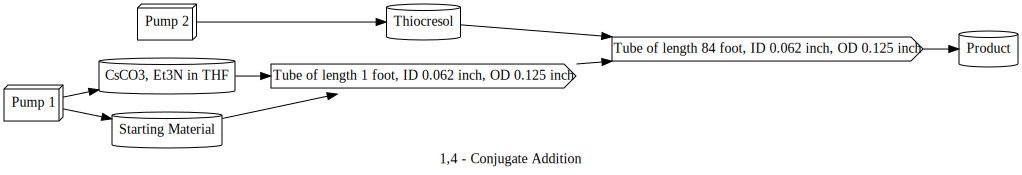

In [48]:
# apparatus 
A = mw.Apparatus("1,4 - Conjugate Addition")

A.add(pump_1, reagent_vessel_1, sugar)
A.add(pump_1, reagent_vessel_2, CsCO3)

A.add(reagent_vessel_1, T_1, sugar)
A.add(reagent_vessel_2, T_1, CsCO3)
A.add(T_1, T_2, activation)

A.add(pump_2, reagent_vessel_3, thiocresol)

A.add(reagent_vessel_3, T_2, thiocresol)
A.add(T_2, product_vessel, addition)

A.describe()
A.visualize()

### Protocol

In [50]:
P = mw.Protocol(A)

switch = timedelta(seconds = 45)

current = timedelta(minutes = 0)

activation = timedelta(minutes = 2)
reaction = timedelta(minutes = 23) 
P.add(pump_1, start = current,
              duration = activation + reaction, rate = "0.5 mL/min")

current += activation

P.add(pump_2, start = current, 
              duration = reaction, rate = "1 mL/min")

current += reaction + switch

flush = timedelta(minutes = 15)
P.add(pump_1, start = current,
              duration = flush, rate = "0.5 mL/min")
P.add(pump_2, start = current, 
              duration = flush, rate = "1 mL/min")

current += flush

print(f'TOTAL TIME: {current}')
P.execute(confirm = True)

TOTAL TIME: 0:40:45


### Product and Yield Information

In [11]:
product = "Deacetylated rhamnal"
product_molecular_weight = 130.14

theoretical_yield = round(moles * product_molecular_weight, decimals = 4)

if molesscale < 0.0005:
    theoretical_yield *= 1000
    units = 'mg'
else:
    units = 'g'

print(product + "; molecular weight: ", product_molecular_weight)

print("Theoretical Yield:", theoretical_yield, units)

actual_yield = float(input(f"Enter mass of product in {units}: "))
print("Actual Yield:", actual_yield, units)

percent_yield = round((actual_yield / theoretical_yield) * 100, decimals = 1)
print("Percent Yield:", percent_yield, "%")

NameError: name 'molesscale' is not defined